Intensity vs Fermi Chopper frequency

Just try the original parameters

In [1]:
workdir = '~/dv/sns-chops/resolution/CNCS/mcvine'
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/dv/sns-chops/resolution/CNCS/mcvine


In [2]:
import numpy as np, os, sys, glob
from matplotlib import pyplot as plt

import histogram.hdf as hh, histogram as H
import mcvine, mcvine.components
from mcni.utils import conversion as C

from matplotlib import pyplot as plt
%matplotlib notebook

/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Explore

In [3]:
mcvine.components.sources.SNS_source_r1?

In [4]:
distance = 1.
emin, emax = 5, 5.005
eave = (emin+emax)/2
v = C.e2v(eave)
tof = distance/v

instrument = mcvine.instrument()
source = mcvine.components.sources.SNS_source_r1(
    'source', 
    S_filename='./a1Gw2-5-f5.dat', width=0.1, height=0.12, dist=0.98,
    xw=0.06, yh=0.11, Emin=emin, Emax=emax)
instrument.append(source, position=(0,0,0))

monitor = mcvine.components.monitors.TOF_monitor2(
    'monitor', filename='Itof.dat', xmin=-0.04, xmax=0.04, ymin=-0.06, ymax=0.06, tmin=tof*.9, tmax=tof*2)
instrument.append(monitor, position=(0,0,1))

In [5]:
%%time
# quick sim
neutrons = instrument.simulate(int(1e3),outputdir="out", overwrite_datafiles=True, iteration_no=0)

CPU times: user 135 ms, sys: 35.2 ms, total: 170 ms
Wall time: 1.11 s


In [6]:
len(neutrons)

1000

In [7]:
ls 

a1Gw2-5-f5.dat  beam-fc-fwhms.txt  beam-fwhms.txt  Itof.dat  out/


In [8]:
ls out/step0/

Itof.h5  number_of_mc_samples


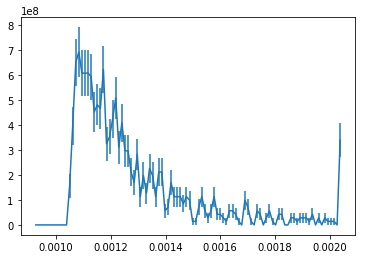

In [9]:
H.plot(hh.load('./out/step0/Itof.h5'))

# Loop

In [42]:
def calculatePulseShape(E, ncount=1e4):
    distance = 1.
    emin, emax = E*0.999, E*1.001
    eave = (emin+emax)/2
    v = C.e2v(eave)
    tof = distance/v

    instrument = mcvine.instrument()
    source = mcvine.components.sources.SNS_source(
        'source', 
        S_filename='./a1Gw2-5-f5.dat', width=0.1, height=0.12, dist=0.98,
        xw=0.06, yh=0.11, Emin=emin, Emax=emax)
    instrument.append(source, position=(0,0,0))

    monitor = mcvine.components.monitors.TOF_monitor2(
        'monitor', filename='Itof.dat', xmin=-0.04, xmax=0.04, ymin=-0.06, ymax=0.06, tmin=tof*.9, tmax=tof*2.2, 
        nchan=500)
    instrument.append(monitor, position=(0,0,1))
    #
    instrument.simulate(int(ncount),outputdir="out", overwrite_datafiles=True, iteration_no=0)
    return hh.load('./out/step0/Itof.h5')

In [43]:
%%time
h = calculatePulseShape(20., ncount=1e5)

CPU times: user 1.92 s, sys: 4.68 ms, total: 1.92 s
Wall time: 1.92 s


<IPython.core.display.Javascript object>


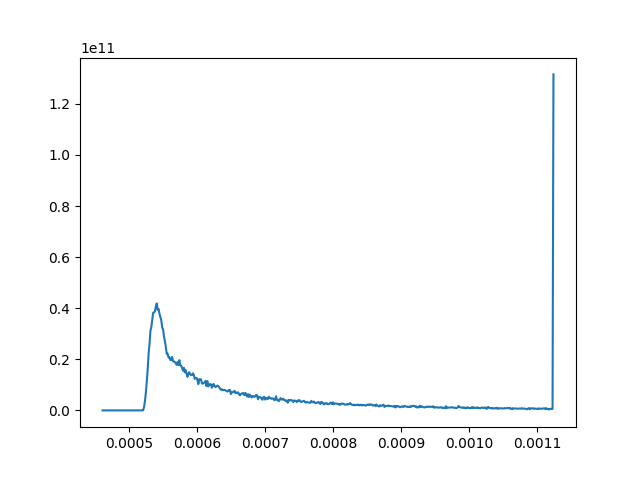

In [44]:
plt.figure()
plt.plot(h.tof, h.I)

In [25]:
Es = np.logspace(-1, 2)

In [26]:
import tqdm

In [45]:
spectra = []
for E in tqdm.tqdm(Es):
    spectra.append(calculatePulseShape(E, ncount=4e5))

100%|██████████| 50/50 [05:24<00:00,  6.43s/it]


In [46]:
%matplotlib notebook

<IPython.core.display.Javascript object>


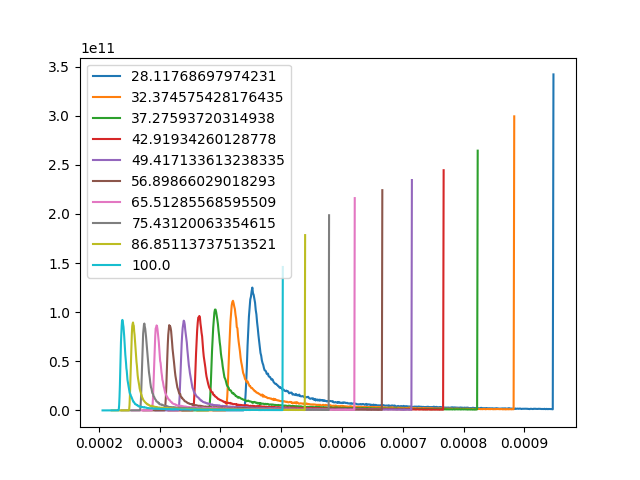

In [47]:
plt.figure()
for E, sp in zip(Es, spectra)[40:50]:
    plt.plot(sp.tof, sp.I, label=E)
plt.legend()

In [48]:
fwhms = []
for E, sp in zip(Es, spectra):
    I = sp.I[:-5]; tof = sp.tof[:-5]
    max = I.max()
    hm = max/2
    top = tof[I>hm]
    fwhms.append(top[-1]-top[0])

In [49]:
fwhms = np.array(fwhms)

In [50]:
np.savetxt('beam-fwhms-SNS_source_r1.txt', np.array([Es, fwhms]).T)

<IPython.core.display.Javascript object>


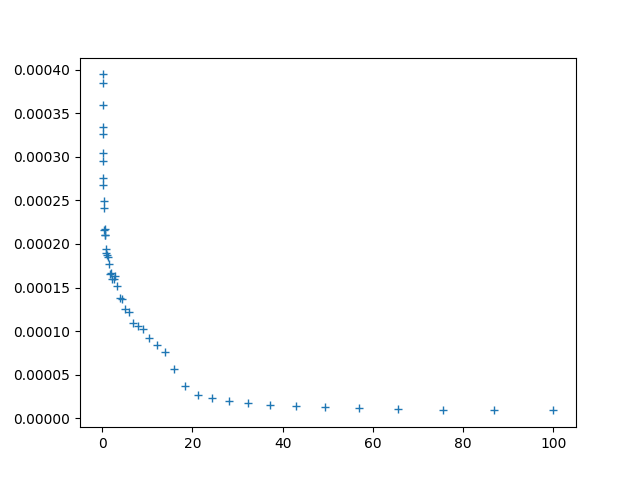

In [51]:
plt.figure()
plt.plot(Es, fwhms, '+')

<IPython.core.display.Javascript object>


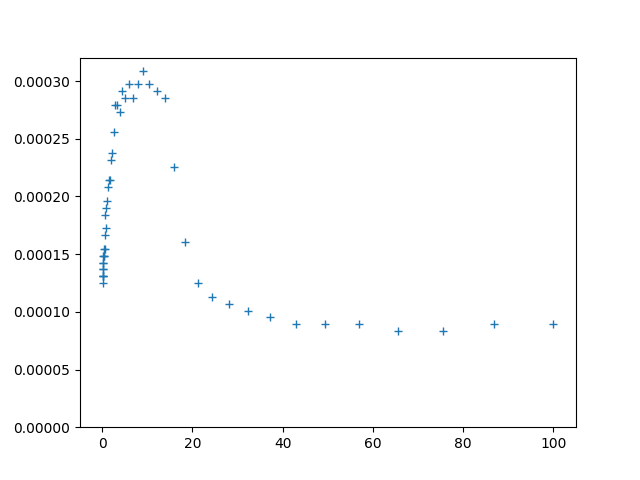

(0, 0.00032039813047613224)

In [52]:
plt.figure()
plt.plot(Es, fwhms*np.sqrt(Es), '+')
plt.ylim(0, None)

Looks like the same as SNS_source